# MSDS_422 Assignment 3 - Linear Regression
#### by Daniel Macdonald @talentrics

**Description: **

This is the 3rd assignment in MSDS 422 - Practical Machine Learning 

**Text:** Thomas W. Miller. Marketing Data Science: Modeling
Techniques in Predictive Analytics with R and Python.
Pearson Education, Old Tappan, N.J., 2015. Data sets and
programs available at http://www.ftpress.com/miller/ and
https://github.com/mtpa/

**Data Source**
https://1.salford-systems.com/Portals/160602/Tutorial%20Datasets/boston.xls

**Table of contents: **

* System & Data Setup
* Data Exploration & Basic Transformation
* Test Model, Dummy Transform & Check
* Model Exploration and Standardization
* Final Model Validataion & Testing
* Conclusion

## System & Data Setup

In [0]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

In [0]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split
from math import sqrt  # for root mean-squared error calculation
import matplotlib # import matplotlib
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map

# suppress warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [0]:
#install PyDrive to pull in csv data
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# https://drive.google.com/file/d/17PCncc0VxBwLc-hD_mbRVQjgToaN5wfI/view?usp=sharing

#download survey data from google drive
downloaded1 = drive.CreateFile({'id': '17PCncc0VxBwLc-hD_mbRVQjgToaN5wfI'})
downloaded1.GetContentFile('boston.csv')


In [0]:
# read data for the Boston Housing Study
# creating data frame restdata
boston_input = pd.read_csv('boston.csv')

## Data Exploration & Basic Transformation

### Basics - Data Frame, Data Types, re-name columns & replace missing values

In [58]:
boston_input = pd.DataFrame(data=boston_input)
boston_input.tail()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
501,Winthrop,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,Winthrop,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,Winthrop,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,Winthrop,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0
505,Winthrop,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,7.88,19.0


In [59]:
boston_input.dtypes

neighborhood     object
crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rooms           float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
lstat           float64
mv              float64
dtype: object

In [0]:
boston_input['neighborhood'].value_counts(); #remove ';' if you want to see result

In [61]:
boston_input.columns

Index(['neighborhood', 'crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age',
       'dis', 'rad', 'tax', 'ptratio', 'lstat', 'mv'],
      dtype='object')

In [62]:
# rename columns to provide more insight to data save as new DataFrame
df_boston = boston_input.copy()

df_boston = df_boston.rename(index=str, columns={
    'crim': 'crime_rate',
    'zn': 'zoned',
    'indus': 'industrial',
    'chas': 'charles_binary',
    'rooms': 'avg_rooms',
    'age': 'pct_pre1940',
    'dis': 'distance_center',
    'rad': 'highway_access',
    'tax': 'avg_tax',
    'lstat': 'pct_lowIncome',
    'mv': 'response_mv'})

df_boston.columns

Index(['neighborhood', 'crime_rate', 'zoned', 'industrial', 'charles_binary',
       'nox', 'avg_rooms', 'pct_pre1940', 'distance_center', 'highway_access',
       'avg_tax', 'ptratio', 'pct_lowIncome', 'response_mv'],
      dtype='object')

In [11]:
#replace any missing values with mean of column just in case

list = ['crime_rate', 'zoned', 'industrial', 'charles_binary',
       'nox', 'avg_rooms', 'pct_pre1940', 'distance_center', 'highway_access',
       'avg_tax', 'ptratio', 'pct_lowIncome', 'response_mv']

#loop through list of continuous variabls and fill nan values with mean value
for i in list:
    df_boston[i] = df_boston[i].fillna((df_boston[i].mean()))
    
df_boston.describe()

,crime_rate,zoned,industrial,charles_binary,nox,avg_rooms,pct_pre1940,distance_center,highway_access,avg_tax,ptratio,pct_lowIncome,response_mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


### Distplot distributions (High Range & Low Range Variables)

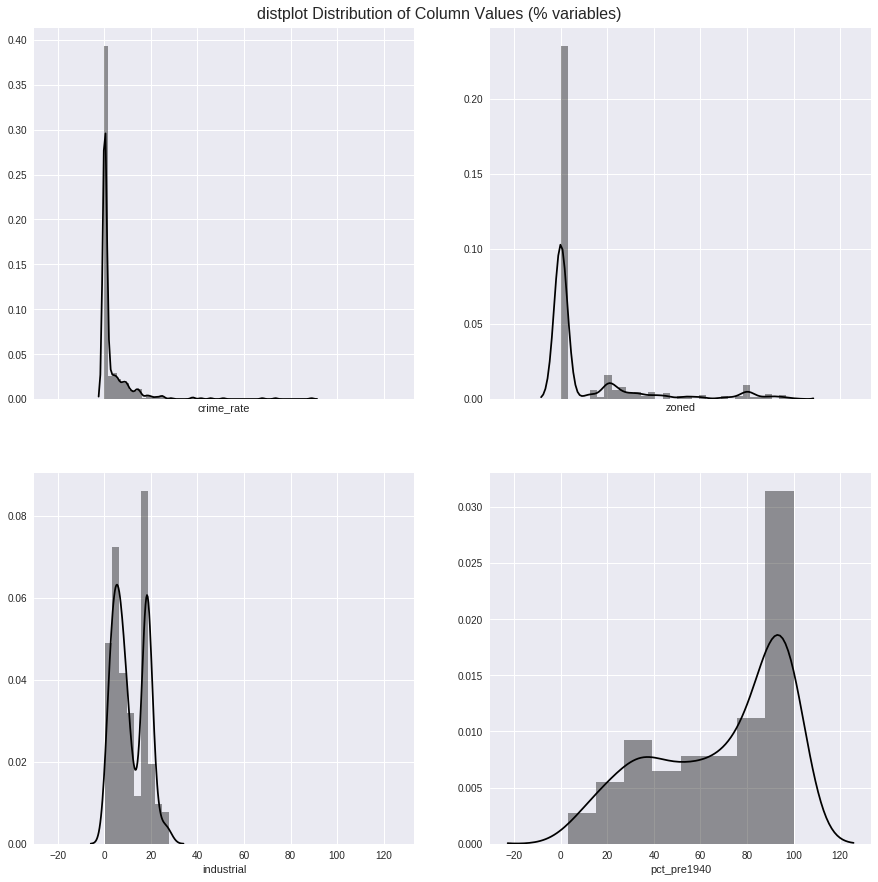

In [12]:
#plot distribution of column values together in one figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
f.suptitle('distplot Distribution of Column Values (% variables)', size = 16, y=.9)
sns.distplot(df_boston["crime_rate"] , color="black", ax=axes[0, 0])
sns.distplot(df_boston["zoned"] , color="black", ax=axes[0, 1])
sns.distplot(df_boston["industrial"] , color="black", ax=axes[1, 0])
sns.distplot(df_boston["pct_pre1940"] , color="black", ax=axes[1, 1])
f.savefig('distplot Distribution of Column Values (% variables)' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

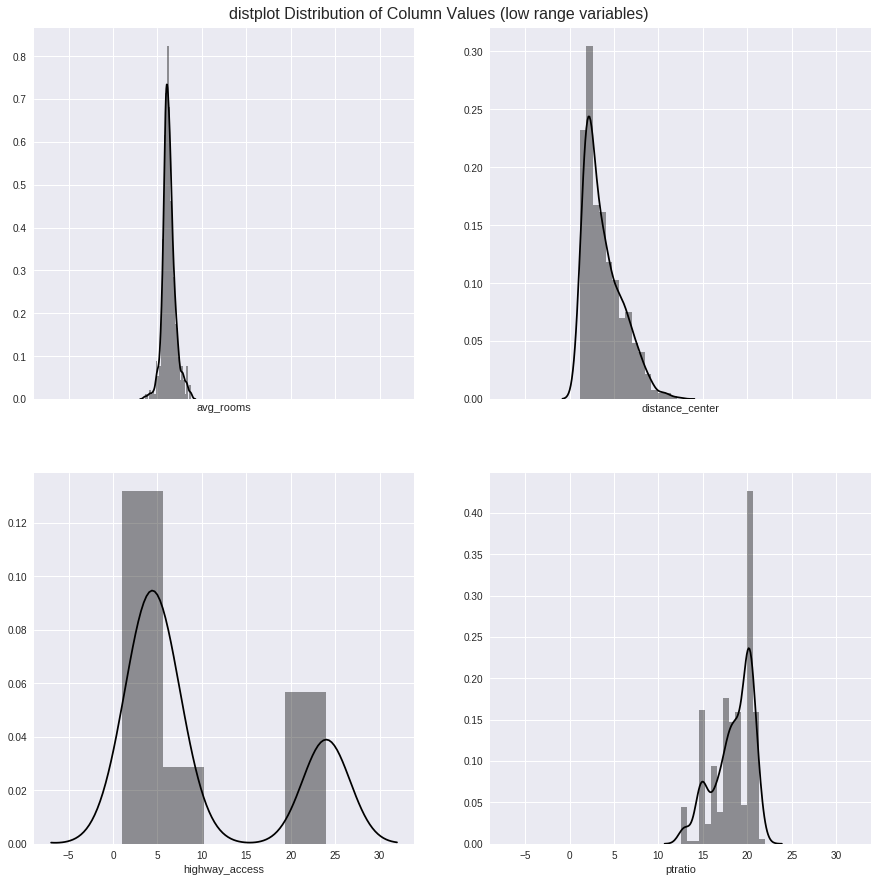

In [13]:
#plot distribution of column values together in one figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
f.suptitle('distplot Distribution of Column Values (low range variables)', size = 16, y=.9)
sns.distplot(df_boston["avg_rooms"] , color="black", ax=axes[0, 0])
sns.distplot(df_boston["distance_center"] , color="black", ax=axes[0, 1])
sns.distplot(df_boston["highway_access"] , color="black", ax=axes[1, 0])
sns.distplot(df_boston["ptratio"] , color="black", ax=axes[1, 1])
f.savefig('distplot Distribution of Column Values (low range variables)' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

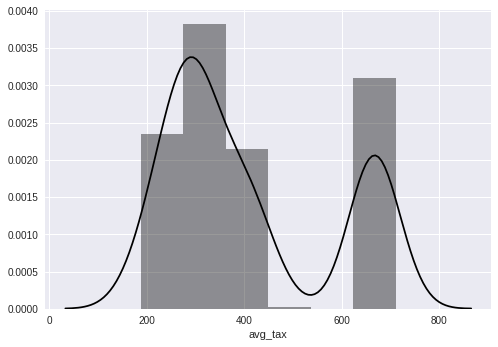

In [14]:
sns.distplot(df_boston["avg_tax"] , color="black")

### Explore regression & correlation - continuous variables

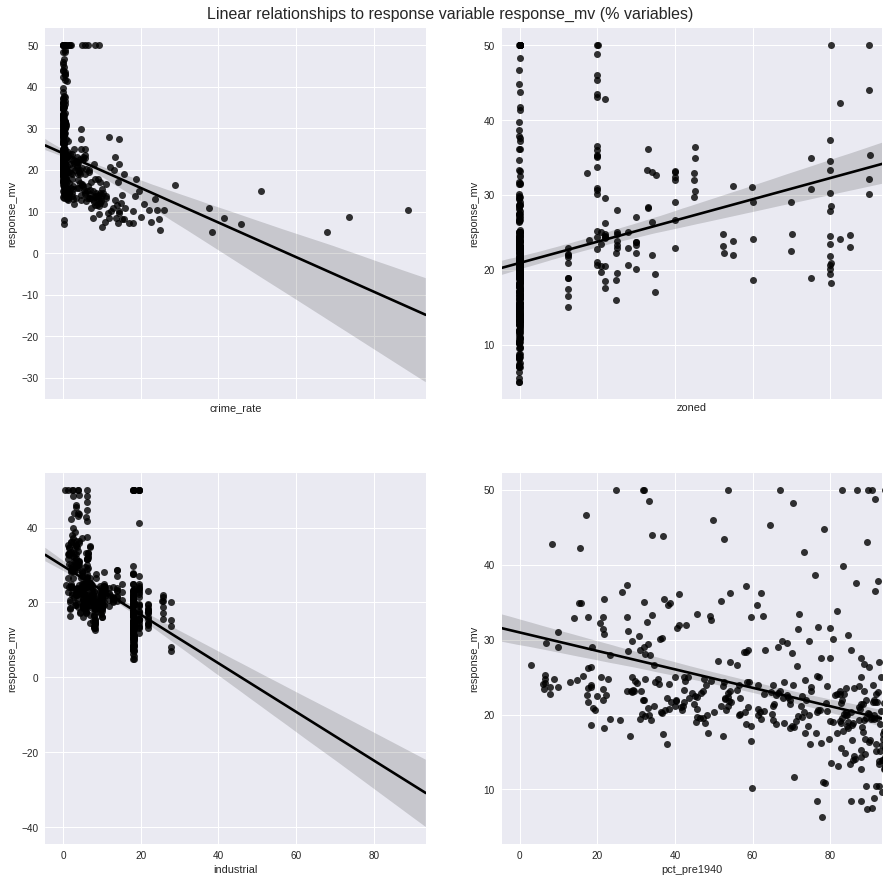

In [15]:
# plot linear relationships with response variable 'response_mv' together in one figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
f.suptitle('Linear relationships to response variable response_mv (% variables)', size = 16, y=.9)
sns.regplot(x="crime_rate", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[0, 0])
sns.regplot(x="zoned", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[0, 1])
sns.regplot(x="industrial", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[1, 0])
sns.regplot(x="pct_pre1940", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[1, 1])
f.savefig('Linear relationships to response variable response_mv (% variables)' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

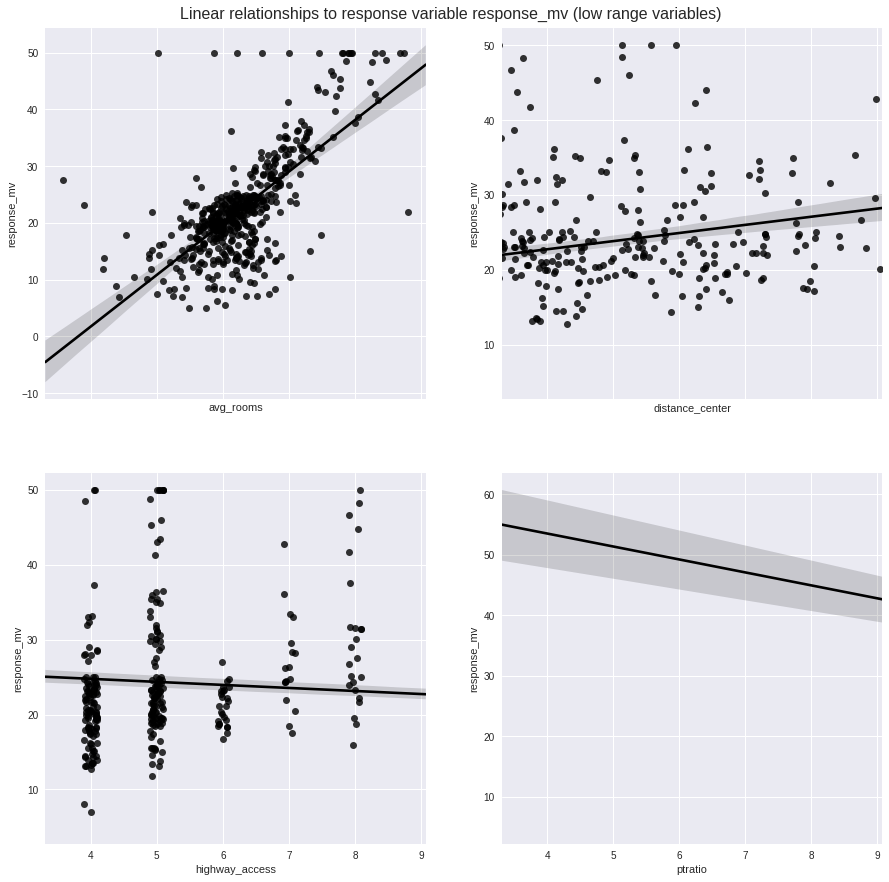

In [16]:
# plot linear relationships with response variable 'response_mv' together in one figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
f.suptitle('Linear relationships to response variable response_mv (low range variables)', size = 16, y=.9)
sns.regplot(x="avg_rooms", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[0, 0])
sns.regplot(x="distance_center", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[0, 1])
sns.regplot(x="highway_access", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[1, 0])
sns.regplot(x="ptratio", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[1, 1])
f.savefig('Linear relationships to response response_mv (low range variables)' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

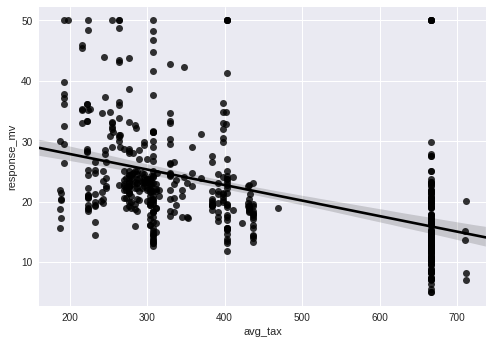

In [17]:
sns.regplot(x="avg_tax", y="response_mv", data=df_boston, x_jitter=.1, color = "black")

### plot correlation - continuous variables

In [0]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

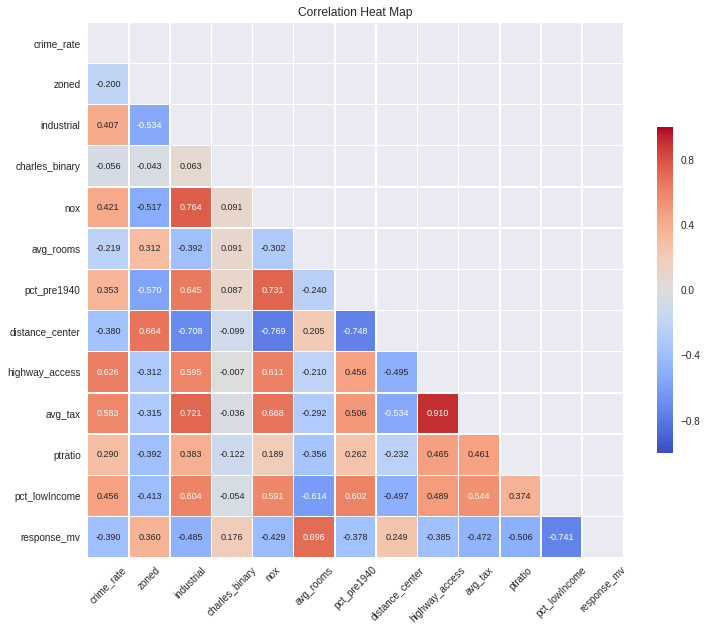

In [64]:
# define subset DataFrame for analysis of software preferences 
Selected = ['crime_rate', 'zoned', 'industrial', 'charles_binary',
       'nox', 'avg_rooms', 'pct_pre1940', 'distance_center', 'highway_access',
       'avg_tax', 'ptratio', 'pct_lowIncome', 'response_mv']

correlation_df = df_boston[Selected]

# examine intercorrelations among software preference variables
# with correlation matrix/heat map
corr_chart(df_corr = correlation_df)  

### explore 'neighborhood' variable

In [65]:
df_boston['neighborhood'].unique()

array(['Nahant', 'Swampscott', 'Swanpscott', 'Marblehead', 'Salem',
       'Lynn', 'Saugus', 'Lynnfield', 'Peabody', 'Danvers', 'Middleton',
       'Topsfield', 'Hamilton', 'Wenham', 'Beverly', 'Manchester',
       'North_Reading', 'Wilmington', 'Burlington', 'Woburn', 'Reading',
       'Wakefield', 'Melrose', 'Stoneham', 'Winchester', 'Medford',
       'Malden', 'Everett', 'Somerville', 'Cambridge', 'Arlington',
       'Belmont', 'Lexington', 'Bedford', 'Lincoln', 'Concord', 'Sudbury',
       'Wayland', 'Weston', 'Waltham', 'Watertown', 'Newton', 'Natick',
       'Framingham', 'Ashland', 'Sherborn', 'Brookline', 'Dedham',
       'Needham', 'Wellesley', 'Dover', 'Medfield', 'Millis', 'Norfolk',
       'Walpole', 'Westwood', 'Norwood', 'Sharon', 'Canton', 'Milton',
       'Quincy', 'Braintree', 'Randolph', 'Holbrook', 'Weymouth',
       'Cohasset', 'Hull', 'Hingham', 'Rockland', 'Hanover', 'Norwell',
       'Scituate', 'Marshfield', 'Duxbury', 'Pembroke',
       'Allston-Brighton', 'Bac

In [66]:
#what are the top 10 neighborhoods by response variable?

neighborhood_ranking = df_boston.copy()

neighborhood_ranking = neighborhood_ranking.drop(columns=['crime_rate', 'zoned', 'industrial', 'charles_binary',
       'nox', 'avg_rooms', 'pct_pre1940', 'distance_center', 'highway_access',
       'avg_tax', 'ptratio', 'pct_lowIncome'])

neighborhood_ranking = neighborhood_ranking.groupby('neighborhood').mean()
neighborhood_ranking = neighborhood_ranking.sort_values('response_mv', ascending = False)
neighborhood_ranking.head(10)

,response_mv
neighborhood,
Lincoln,50.000
Beacon_Hill,50.000
Dover,50.000
Weston,49.250
Sherborn,44.000
Wellesley,40.475
Brookline,38.025
Belmont,36.200
Topsfield,35.400


In [67]:
#what are the bottom 10 neighborhoods by response variable?
neighborhood_ranking.tail(10)

,response_mv
neighborhood,
Somerville,17.093333
Lynn,16.713636
Hull,16.500000
North_End,13.800000
Savin_Hill,13.234783
Chelsea,12.800000
Charlestown,12.400000
Roxbury,11.615789
East_Boston,11.563636


## Test model - Linear regression using only continuous variables (drop Neighborhood)

#### test model - split data from response (without neighborhood)

In [0]:
test_model_X = df_boston.copy()
test_model_y = df_boston.copy()

# split dataframe by data and response variables and make array for train_test_split
#remove response variable from data and save as df_data
test_model_X = test_model_X.drop(columns=['neighborhood','response_mv'])
#remove all but response variable and save as df_response
test_model_y = pd.DataFrame(test_model_y['response_mv'])

#check data df
test_model_X.head(); #remove ';' if you want to see result

In [0]:
#check response df
test_model_y.head(); #remove ';' if you want to see result

#### test model - Use 'Plot Learning Curves' to determine train/test split

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

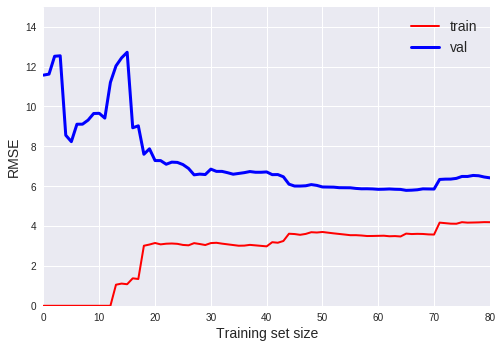

In [72]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, test_model_X, test_model_y)
plt.axis([0, 80, 0, 15])                         # not shown in the book
plt.show()                                      # not shown

**recommended train/test split at 70/30 but RMSE is very high (between 4 & 6)**

#### test model - train test split

In [0]:
#split data by training & test sets
X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(\
    test_model_X, test_model_y,test_size=.3, random_state=10)

In [0]:
X_train_test.describe(); #remove ';' if you want to see output

In [0]:
y_train_test.describe(); #remove ';' if you want to see output

#### test model - linear regression with validation

lr_test.coef_:[[-1.542e-01  6.840e-02 -4.077e-02  1.922e+00 -1.708e+01  2.917e+00
   1.741e-02 -1.610e+00  2.668e-01 -1.302e-02 -7.723e-01 -5.960e-01]]
lr_test.intercept_:[43.134]
Training set score: 0.74
Test set score: 0.71


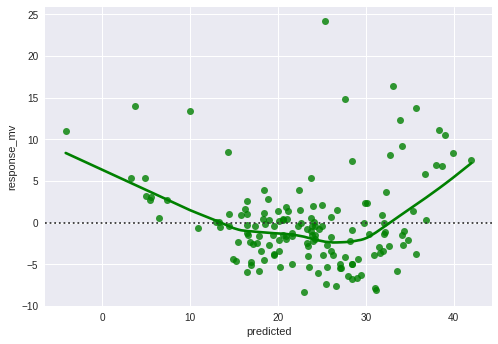

In [74]:
#using sklearn LinearRegression, create test model:
from sklearn.linear_model import LinearRegression
lr_test = LinearRegression().fit(X_train_test,y_train_test)

#print coeficients, intercept, Training & Test scores: 
print("lr_test.coef_:{}".format(lr_test.coef_))
print("lr_test.intercept_:{}".format(lr_test.intercept_))
print("Training set score: {:.2f}".format(lr_test.score(X_train_test, y_train_test)))
print("Test set score: {:.2f}".format(lr_test.score(X_test_test, y_test_test)))

#plot residuals to check fit:
y_test_chk = y_test_test.copy()
y_test_chk['predicted']=lr_test.predict(X_test_test)
# Plot the residuals after fitting a linear model
sns.residplot(y_test_chk['predicted'], y_test_chk['response_mv'], lowess=True, color="g")

**Training/Test scores ~71 and curved residual plot and high range of values.  Analysis - poor fit**

## Dummy transform & re-check model

### Create dummy variables from 'neighborhood'

In [18]:
df_Bdata_imp = df_boston.copy()

#create a list of columns with yes/no values to convert to 0 and 1
list_dummies = ['neighborhood']

#use the pd 'get_dummies' method to create dummy variables for all object lists: 
for column_name in list_dummies:
    dummies = pd.get_dummies(df_Bdata_imp[column_name], prefix='value', prefix_sep='_')
    col_names_dummies = dummies.columns.values

    #then you can append new columns to the dataframe
    for i,value in enumerate(col_names_dummies):
        df_Bdata_imp[value] = dummies.iloc[:,i]

#drop categorical columns and keep dummy columns:
df_Bdata_imp = df_Bdata_imp.drop(columns=['neighborhood'], axis = 1)
#df_bank_imp = df_bank_imp.rename(columns={'value_yes': 'y_target_yes'})
df_Bdata_imp.describe()

,crime_rate,zoned,industrial,charles_binary,nox,avg_rooms,pct_pre1940,distance_center,highway_access,avg_tax,...,value_Wellesley,value_Wenham,value_West_Roxbury,value_Weston,value_Westwood,value_Weymouth,value_Wilmington,value_Winchester,value_Winthrop,value_Woburn
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,...,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,...,0.007905,0.001976,0.007905,0.003953,0.005929,0.015810,0.005929,0.009881,0.009881,0.011858
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,...,0.088646,0.044455,0.088646,0.062807,0.076846,0.124864,0.076846,0.099011,0.099011,0.108353
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### test Model 2 - split data from response (w/ neighborhoods)

In [0]:
test2_model_X = df_Bdata_imp.copy()
test2_model_y = df_Bdata_imp.copy()

# split dataframe by data and response variables and make array for train_test_split
#remove response variable from data and save as df_data
test2_model_X = test2_model_X.drop(columns=['response_mv'])
#remove all but response variable and save as df_response
test2_model_y = pd.DataFrame(test2_model_y['response_mv'])

#check data df
test2_model_X.head(); #remove ';' if you want to see result

### test Model 2 - Use 'Plot Learning Curves' to determine train/test split

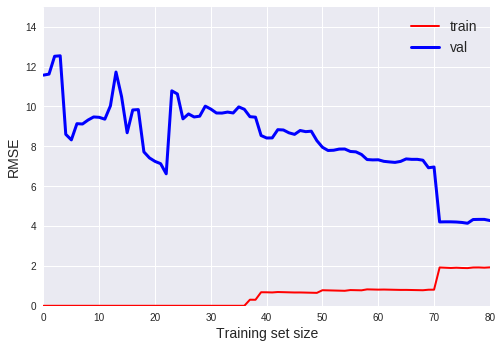

In [22]:
#'plot_learning_curves' defined under 'test model':
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, test2_model_X, test2_model_y)
plt.axis([0, 80, 0, 15])                         # not shown in the book
plt.show()                                      # not shown

**recommended train/test split at 70/30 RMSE Improved (between 2 & 4)**

### test Model 2 - train/test split & validation

In [0]:
#split data by training & test sets
X_train_test2, X_test_test2, y_train_test2, y_test_test2 = train_test_split(\
    test2_model_X, test2_model_y,test_size=.3, random_state=10)

Training set score: 0.89
Test set score: -647055875548452.75


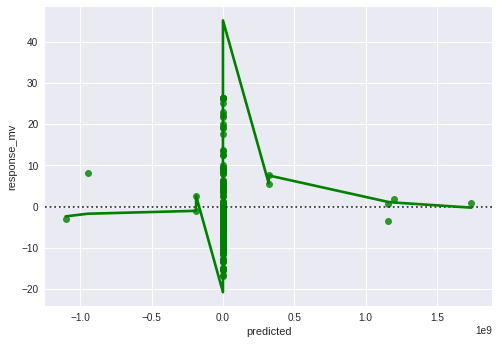

In [77]:
#using sklearn LinearRegression, create test model:
from sklearn.linear_model import LinearRegression
lr_test2 = LinearRegression().fit(X_train_test2,y_train_test2)

#print coeficients, intercept, Training & Test scores: 
print("Training set score: {:.2f}".format(lr_test2.score(X_train_test2, y_train_test2)))
print("Test set score: {:.2f}".format(lr_test2.score(X_test_test2, y_test_test2)))

#plot residuals to check fit:
y_test2_chk = y_test_test2.copy()
y_test2_chk['predicted']=lr_test2.predict(X_test_test2)
# Plot the residuals after fitting a linear model
sns.residplot(y_test2_chk['predicted'], y_test2_chk['response_mv'], lowess=True, color="g")

**Analysis - overfitting - high training test score but very low test set score - try regularization & scaling**

## Model 1- Regularized Ridge Regression

### Model 1 (Ridge) Data Prep & Training/Test split

In [0]:
R1_model_X = df_Bdata_imp.copy()
R1_model_y = df_Bdata_imp.copy()

# split dataframe by data and response variables and make array for train_test_split
#remove response variable from data and save as df_data
R1_model_X = R1_model_X.drop(columns=['response_mv'])
#remove all but response variable and save as df_response
R1_model_y = pd.DataFrame(R1_model_y['response_mv'])

#split data by training & test sets
X_train_R1, X_test_R1, y_train_R1, y_test_R1 = train_test_split(\
    R1_model_X, R1_model_y,test_size=.3, random_state=10)

In [0]:
X_train_R1.head(); # check split x

In [0]:
y_train_R1.head(); #check split y

### Model 1 (Ridge) Model Creation & Validation

Training set score: 0.89
Test set score: 0.85
Number of features used: 98


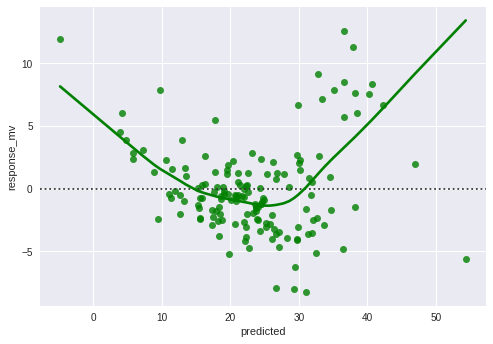

In [50]:
from sklearn.linear_model import Ridge
ridge1 = Ridge(alpha=.001, solver="cholesky").fit(X_train_R1,y_train_R1)

print("Training set score: {:.2f}".format(ridge1.score(X_train_R1,y_train_R1)))
print("Test set score: {:.2f}".format(ridge1.score(X_test_R1,y_test_R1)))
print("Number of features used: {}".format(np.sum(ridge1.coef_ !=0)))

y_R1_chk = y_test_R1.copy()
y_R1_chk['predicted']=ridge1.predict(X_test_R1)
# Plot the residuals after fitting a linear model
sns.residplot(y_R1_chk['predicted'], y_R1_chk['response_mv'], lowess=True, color="g")

**Analysis - improved fit with regularization - Training/test scores match ~.85/.89**

## Model 2 - Regularized Lasso Regression

### Model 2 (Lasso) Data Prep & Training/Test split

In [0]:
L1_model_X = df_Bdata_imp.copy()
L1_model_y = df_Bdata_imp.copy()

# split dataframe by data and response variables and make array for train_test_split
#remove response variable from data and save as df_data
L1_model_X = L1_model_X.drop(columns=['response_mv'])
#remove all but response variable and save as df_response
L1_model_y = pd.DataFrame(L1_model_y['response_mv'])

#split data by training & test sets
X_train_L1, X_test_L1, y_train_L1, y_test_L1 = train_test_split(\
    L1_model_X, L1_model_y,test_size=.3, random_state=10)

In [0]:
X_train_L1.head(); # check split x

In [0]:
y_train_L1.head(); #check split y

### Model 2 (Lasso) Model Creation & Validation

Training set score: 0.89
Test set score: 0.85
Number of features used: 89


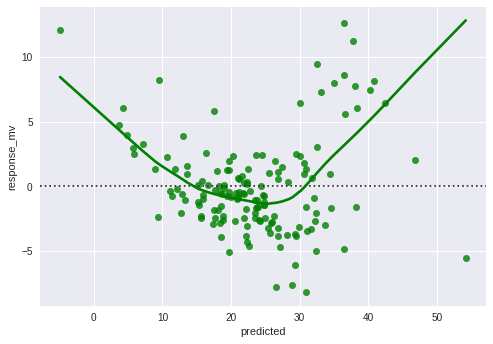

In [52]:
from sklearn.linear_model import Lasso

lasso01 = Lasso(alpha=.001, max_iter = 10000).fit(X_train_L1,y_train_L1)

print("Training set score: {:.2f}".format(lasso01.score(X_train_L1,y_train_L1)))
print("Test set score: {:.2f}".format(lasso01.score(X_test_L1,y_test_L1)))
print("Number of features used: {}".format(np.sum(lasso01.coef_ !=0)))

y_L1_chk = y_test_L1.copy()
y_L1_chk['predicted']=lasso01.predict(X_test_L1)

# Plot the residuals after fitting a lasso model
sns.residplot(y_L1_chk['predicted'], y_L1_chk['response_mv'], lowess=True, color="g")


## model 3 & 4 - Ridge Model with exploration of Scaling & removed outliers

### Use MinMax Scaler and split Train/Test

In [80]:
df_Boston_Scaled = df_Bdata_imp.copy()
column_titles = df_Bdata_imp.columns

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_Boston_Scaled = scaler.fit_transform(df_Boston_Scaled)
df_Boston_Scaled = pd.DataFrame(df_Boston_Scaled, columns = column_titles)
df_Boston_Scaled.describe()

,crime_rate,zoned,industrial,charles_binary,nox,avg_rooms,pct_pre1940,distance_center,highway_access,avg_tax,...,value_Wellesley,value_Wenham,value_West_Roxbury,value_Weston,value_Westwood,value_Weymouth,value_Wilmington,value_Winchester,value_Winthrop,value_Woburn
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,...,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.040544,0.113636,0.391378,0.069170,0.349167,0.521869,0.676364,0.242381,0.371713,0.422208,...,0.007905,0.001976,0.007905,0.003953,0.005929,0.015810,0.005929,0.009881,0.009881,0.011858
std,0.096679,0.233225,0.251479,0.253994,0.238431,0.134627,0.289896,0.191482,0.378576,0.321636,...,0.088646,0.044455,0.088646,0.062807,0.076846,0.124864,0.076846,0.099011,0.099011,0.108353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000851,0.000000,0.173387,0.000000,0.131687,0.445392,0.433831,0.088259,0.130435,0.175573,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.002812,0.000000,0.338343,0.000000,0.314815,0.507281,0.768280,0.188949,0.173913,0.272901,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.041258,0.125000,0.646628,0.000000,0.491770,0.586798,0.938980,0.369088,1.000000,0.914122,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


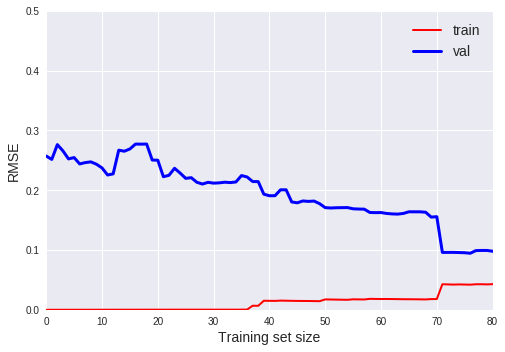

In [81]:
MinMax_model_X = df_Boston_Scaled.copy()
MinMax_model_y = df_Boston_Scaled.copy()

# split dataframe by data and response variables and make array for train_test_split
#remove response variable from data and save as df_data
MinMax_model_X = MinMax_model_X.drop(columns=['response_mv'])
#remove all but response variable and save as df_response
MinMax_model_y = pd.DataFrame(MinMax_model_y['response_mv'])

#'plot_learning_curves' defined under 'test model':
r_model = Ridge(alpha=.0001, solver="cholesky")
plot_learning_curves(r_model, MinMax_model_X, MinMax_model_y)
plt.axis([0, 80, 0, .5])                         # not shown in the book
plt.show()                                      # not shown

In [0]:
#split data by training & test sets
X_train_MinMax, X_test_MinMax, y_train_MinMax, y_test_MinMax = train_test_split(\
    MinMax_model_X, MinMax_model_y,test_size=.3, random_state=10)

In [0]:
X_train_MinMax.head(); #test split X

In [0]:
y_train_MinMax.head(); #test split y

### Model 3 - Scaled Ridge Regression (MinMax)

Training set score: 0.89
Test set score: 0.85


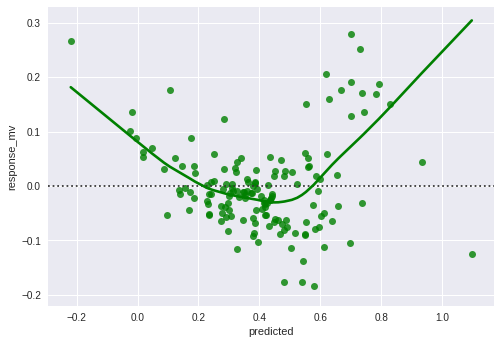

In [83]:
from sklearn.linear_model import Ridge
ridge2 = Ridge(alpha=.0001, solver="cholesky").fit(X_train_MinMax,y_train_MinMax)

print("Training set score: {:.2f}".format(ridge2.score(X_train_MinMax,y_train_MinMax)))
print("Test set score: {:.2f}".format(ridge2.score(X_test_MinMax,y_test_MinMax)))

y_R2_chk = y_test_MinMax.copy()
y_R2_chk['predicted']=ridge2.predict(X_test_MinMax)
# Plot the residuals after fitting a linear model
sns.residplot(y_R2_chk['predicted'], y_R2_chk['response_mv'], lowess=True, color="g")

### Model 4 - Scaled Ridge Regression (Robust) with removed outliers

In [34]:
df_Boston_Scaled2 = df_Bdata_imp.copy()
df_Boston_Scaled2['chk_c'] = (df_Boston_Scaled2['response_mv']/df_Boston_Scaled2['avg_rooms'])
df_Boston_Scaled2.head()

,crime_rate,zoned,industrial,charles_binary,nox,avg_rooms,pct_pre1940,distance_center,highway_access,avg_tax,...,value_Wenham,value_West_Roxbury,value_Weston,value_Westwood,value_Weymouth,value_Wilmington,value_Winchester,value_Winthrop,value_Woburn,chk_c
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,...,0,0,0,0,0,0,0,0,0,3.650190
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,...,0,0,0,0,0,0,0,0,0,3.363962
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,...,0,0,0,0,0,0,0,0,0,4.829506
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,...,0,0,0,0,0,0,0,0,0,4.772792
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,...,0,0,0,0,0,0,0,0,0,5.065062


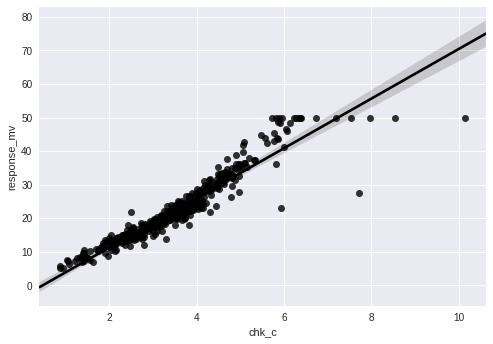

In [36]:
sns.regplot(x="chk_c", y="response_mv", data=df_Boston_Scaled2, x_jitter=.1, color = "black")

In [37]:
df_Boston_Scaled2 = df_Boston_Scaled2.drop(df_Boston_Scaled2[df_Boston_Scaled2['chk_c']>8].index)
df_Boston_Scaled2.describe()

,crime_rate,zoned,industrial,charles_binary,nox,avg_rooms,pct_pre1940,distance_center,highway_access,avg_tax,...,value_Wenham,value_West_Roxbury,value_Weston,value_Westwood,value_Weymouth,value_Wilmington,value_Winchester,value_Winthrop,value_Woburn,chk_c
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,...,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,3.590547,11.431412,11.095249,0.067594,0.554166,6.288199,68.408151,3.810458,9.463221,406.699801,...,0.001988,0.007952,0.003976,0.005964,0.015905,0.005964,0.009940,0.009940,0.011928,3.493788
std,8.620840,23.375438,6.859608,0.251299,0.116012,0.702013,28.146949,2.102452,8.661067,167.854339,...,0.044588,0.088909,0.062994,0.077074,0.125231,0.077074,0.099303,0.099303,0.108672,1.099250
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.137000,1.000000,187.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.879817
25%,0.081930,0.000000,5.160000,0.000000,0.449000,5.887500,44.700000,2.105250,4.000000,279.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.856406
50%,0.253560,0.000000,9.690000,0.000000,0.538000,6.209000,77.000000,3.215700,5.000000,330.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.470350
75%,3.551845,12.500000,18.100000,0.000000,0.624000,6.627000,93.950000,5.213250,24.000000,666.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.012747
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.722550


In [45]:
#df_Boston_Scaled2 = df_Bdata_imp.copy()
column_titles = df_Boston_Scaled2.columns

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df_Boston_Scaled2 = scaler.fit_transform(df_Boston_Scaled2)
df_Boston_Scaled2 = pd.DataFrame(df_Boston_Scaled2, columns = column_titles)
df_Boston_Scaled2.describe()

,crime_rate,zoned,industrial,charles_binary,nox,avg_rooms,pct_pre1940,distance_center,highway_access,avg_tax,...,value_Wenham,value_West_Roxbury,value_Weston,value_Westwood,value_Weymouth,value_Wilmington,value_Winchester,value_Winthrop,value_Woburn,chk_c
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,...,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,0.961691,0.914513,0.108597,0.067594,0.092379,0.107098,-0.174454,0.191364,0.223161,0.198191,...,0.001988,0.007952,0.003976,0.005964,0.015905,0.005964,0.009940,0.009940,0.011928,0.020269
std,2.484453,1.870035,0.530109,0.251299,0.662927,0.949307,0.571512,0.676465,0.433053,0.433732,...,0.044588,0.088909,0.062994,0.077074,0.125231,0.077074,0.099303,0.099303,0.108672,0.950628
min,-0.071252,0.000000,-0.713292,0.000000,-0.874286,-3.580798,-1.504569,-0.668822,-0.200000,-0.369509,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.240285
25%,-0.049462,0.000000,-0.350077,0.000000,-0.508571,-0.434753,-0.655838,-0.357288,-0.050000,-0.131783,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.530938
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.950538,1.000000,0.649923,0.000000,0.491429,0.565247,0.344162,0.642712,0.950000,0.868217,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.469062
max,25.569110,8.000000,1.394900,1.000000,1.902857,3.476673,0.467005,2.867053,0.950000,0.984496,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.677289


In [0]:
Robust_model_X = df_Boston_Scaled2.copy()
Robust_model_y = df_Boston_Scaled2.copy()

# split dataframe by data and response variables and make array for train_test_split
#remove response variable from data and save as df_data
Robust_model_X = Robust_model_X.drop(columns=(['response_mv','chk_c']))
#remove all but response variable and save as df_response
Robust_model_y = pd.DataFrame(Robust_model_y['response_mv'])

#split data by training & test sets
X_train_Robust, X_test_Robust, y_train_Robust, y_test_Robust = train_test_split(\
    Robust_model_X, Robust_model_y,test_size=.3, random_state=10)

Training set score: 0.91
Test set score: 0.80


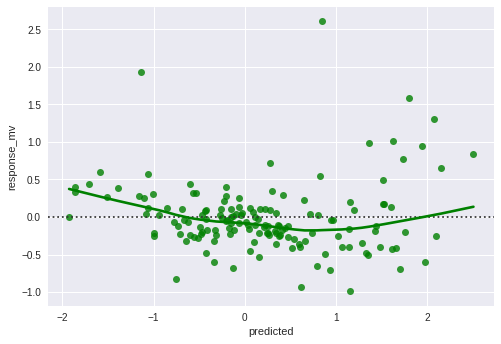

In [47]:
ridge3 = Ridge(alpha=.0001, solver="cholesky").fit(X_train_Robust,y_train_Robust)

print("Training set score: {:.2f}".format(ridge3.score(X_train_Robust,y_train_Robust)))
print("Test set score: {:.2f}".format(ridge3.score(X_test_Robust,y_test_Robust)))

y_Robust_chk = y_test_Robust.copy()
y_Robust_chk['predicted']=ridge3.predict(X_test_Robust)
# Plot the residuals after fitting a linear model
sns.residplot(y_Robust_chk['predicted'], y_Robust_chk['response_mv'], lowess=True, color="g")

## Conclusion

**Recommended model - Lasso regression without scaling**

All other models perform similarly (.89 : .85 test scores for training/test data) with fewest coefficients.